**Introduction**

On s'intéresse à la génération d'ensemble d'erreurs corrélées sur un champs 1D. Pour corréler les erreurs, deux champs paramétriques sont nécessaires : 
le champs de variance des erreurs et le champs de longueur de portée.
Ce calepin illustre la génération de champs d'erreur avec différentes paramétrisations : 
- une variance et une longueur de portée constantes
- une variance hétérogène et une longueur de portée constante
- une variance constante et une longueur de portée hétérogène
- une variance et une longueur de portée hétérogènes



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# I. Définition du domaine

In [2]:
import sympy
sympy.init_printing() 

In [3]:
from sympy import Function, Derivative, Eq, symbols, factor
from sympkf import PDESystem, FDModelBuilder

In [4]:
t, x, y = symbols('t x y')
lbda = symbols('lambda')

psi = Function('psi')(t, x)

In [5]:
# set the equations
Equation = [Eq(Derivative(psi, t), 0)]

In [6]:
PDESystem(Equation)

PDE System :
        prognostic functions : psi(t, x)
        constant functions   : 
        exogeneous functions : 
        constants            : 
        

In [7]:
# set the lengths of the domain
lengths = (1,)

# set yhe number of points
nx = 241
shape = (lengths[0]*nx,)

# set lambda
lbda = 0.01

In [8]:
# generate the domain

exec(FDModelBuilder(Equation, class_name='Psi').code)
pkf_psi = Psi(shape, lengths = lengths)

In [9]:
domain_1D = pkf_psi

# II. Génération matrice de covariance

Le domaine de définition est un champs 1D discrétisé en 241 points. La matrice de covariance est définit à partir d'une gaussienne avec comme paramètre le champs de variance et le champs de longueur de portée :

$$\mathbb{P}(V, lh)(x, y) = \sqrt{V(x)V(y)} \frac{|{lh_x|^{1/4}}|lh_y|^{1/4}}{|\frac{1}{2}(lh_x + lh_y)|^{1/2}} * exp(-||x-y||_{(lh_x+lh_y)^{-1}}^2)$$


In [10]:
def Covariance_matrix(domain, V, lh):
    gauss_q = lambda dx, lh : np.exp(-0.5*dx**2/lh**2)
    
    mesh_x, mesh_lh = np.meshgrid(domain.x[0], lh)
    
    correlation_q = gauss_q(domain.x[0]-domain.x[0][domain.shape[0]//2], mesh_lh)
    for i in range(domain.shape[0]):
        correlation_q[i] = V[i]*np.roll(correlation_q[i], -i+domain.shape[0]//2, axis=0)
    return correlation_q

In [11]:
def make_sample_1D(domain, V, lh):  
    
    covariance = Covariance_matrix(domain, V, lh)
    [U,D,V] = np.linalg.svd(covariance)
    std_covariance = U@np.sqrt(np.diag(D))@U.T
    
    # make sample
    zeta = np.array([np.random.normal(size=domain_1D.shape[0])]).T
    
    ef_q = np.dot(std_covariance,zeta) 
    
    return ef_q.T[0]

## 1) Génération d'erreur avec une variance et une longueur de portée constantes

### Matrice de Covariance

In [12]:
lh, V = [0.1, 0.02], [1,0.1]


V_high = np.array([V[0]]*domain_1D.shape[0])
lh_high = np.array([lh[0]]*domain_1D.shape[0])
V_low = np.array([V[1]]*domain_1D.shape[0])
lh_low = np.array([lh[1]]*domain_1D.shape[0])

In [13]:
matrix1 = Covariance_matrix(domain_1D, V_high, lh_high)
matrix2 = Covariance_matrix(domain_1D, V_high, lh_low)
matrix3 = Covariance_matrix(domain_1D, V_low, lh_high)
matrix4 = Covariance_matrix(domain_1D, V_low, lh_low)

Text(0, 0.5, 'domain')

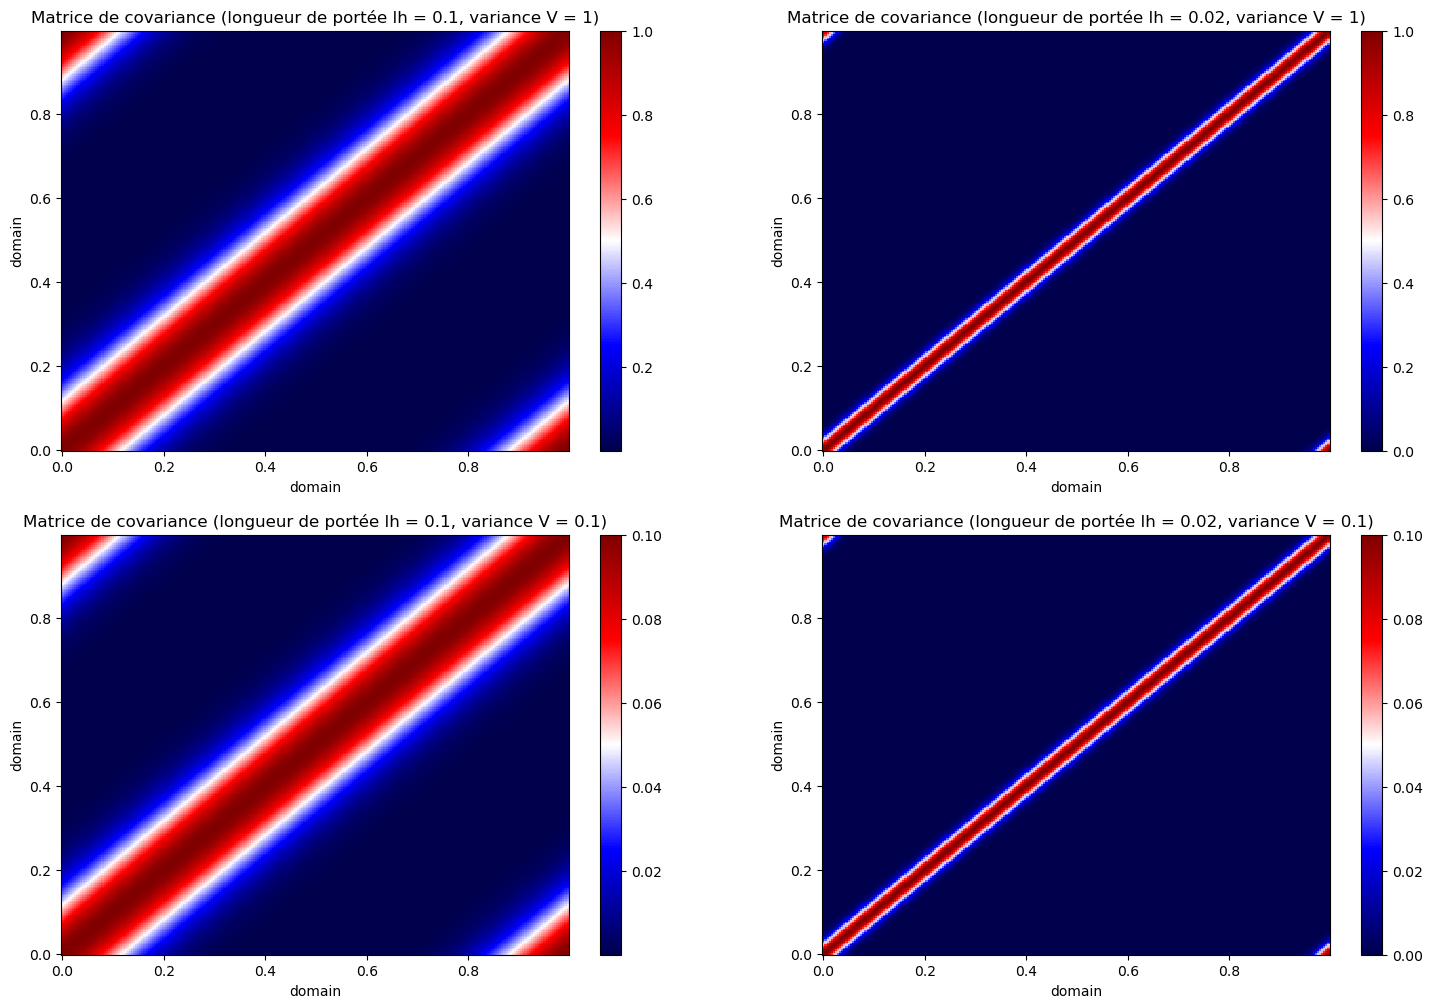

In [14]:
plt.figure(figsize=(18,12))

plt.subplot(221)
plt.pcolormesh(np.flip(domain_1D.x[0]), domain_1D.x[0], matrix1, cmap='seismic')
plt.colorbar()

plt.title(f'Matrice de covariance (longueur de portée lh = {lh[0]}, variance V = {V[0]})')
plt.xlabel('domain')
plt.ylabel('domain')

plt.subplot(222)
plt.pcolormesh(np.flip(domain_1D.x[0]), domain_1D.x[0], matrix2, cmap='seismic')
plt.colorbar()

plt.title(f'Matrice de covariance (longueur de portée lh = {lh[1]}, variance V = {V[0]})')
plt.xlabel('domain')
plt.ylabel('domain')

plt.subplot(223)
plt.pcolormesh(np.flip(domain_1D.x[0]), domain_1D.x[0], matrix3, cmap='seismic')
plt.colorbar()

plt.title(f'Matrice de covariance (longueur de portée lh = {lh[0]}, variance V = {V[1]})')
plt.xlabel('domain')
plt.ylabel('domain')

plt.subplot(224)
plt.pcolormesh(np.flip(domain_1D.x[0]), domain_1D.x[0], matrix4, cmap='seismic')
plt.colorbar()

plt.title(f'Matrice de covariance (longueur de portée lh = {lh[1]}, variance V = {V[1]})')
plt.xlabel('domain')
plt.ylabel('domain')

La longueur de portée représente la distance pour laquelle une erreur a une influence sur les erreurs voisins. 
La variance a une influence sur l'amplitude des erreurs : plus la variance est grande, plus l'amplitude de l'erreur peut etre grande.

### Génération d'un champs d'erreur

In [15]:
e1 = make_sample_1D(domain_1D, V_high, lh_high)
e2 = make_sample_1D(domain_1D, V_high, lh_low)
e3 = make_sample_1D(domain_1D, V_low, lh_high)
e4 = make_sample_1D(domain_1D, V_low, lh_low)

Text(0.5, 0, 'domain')

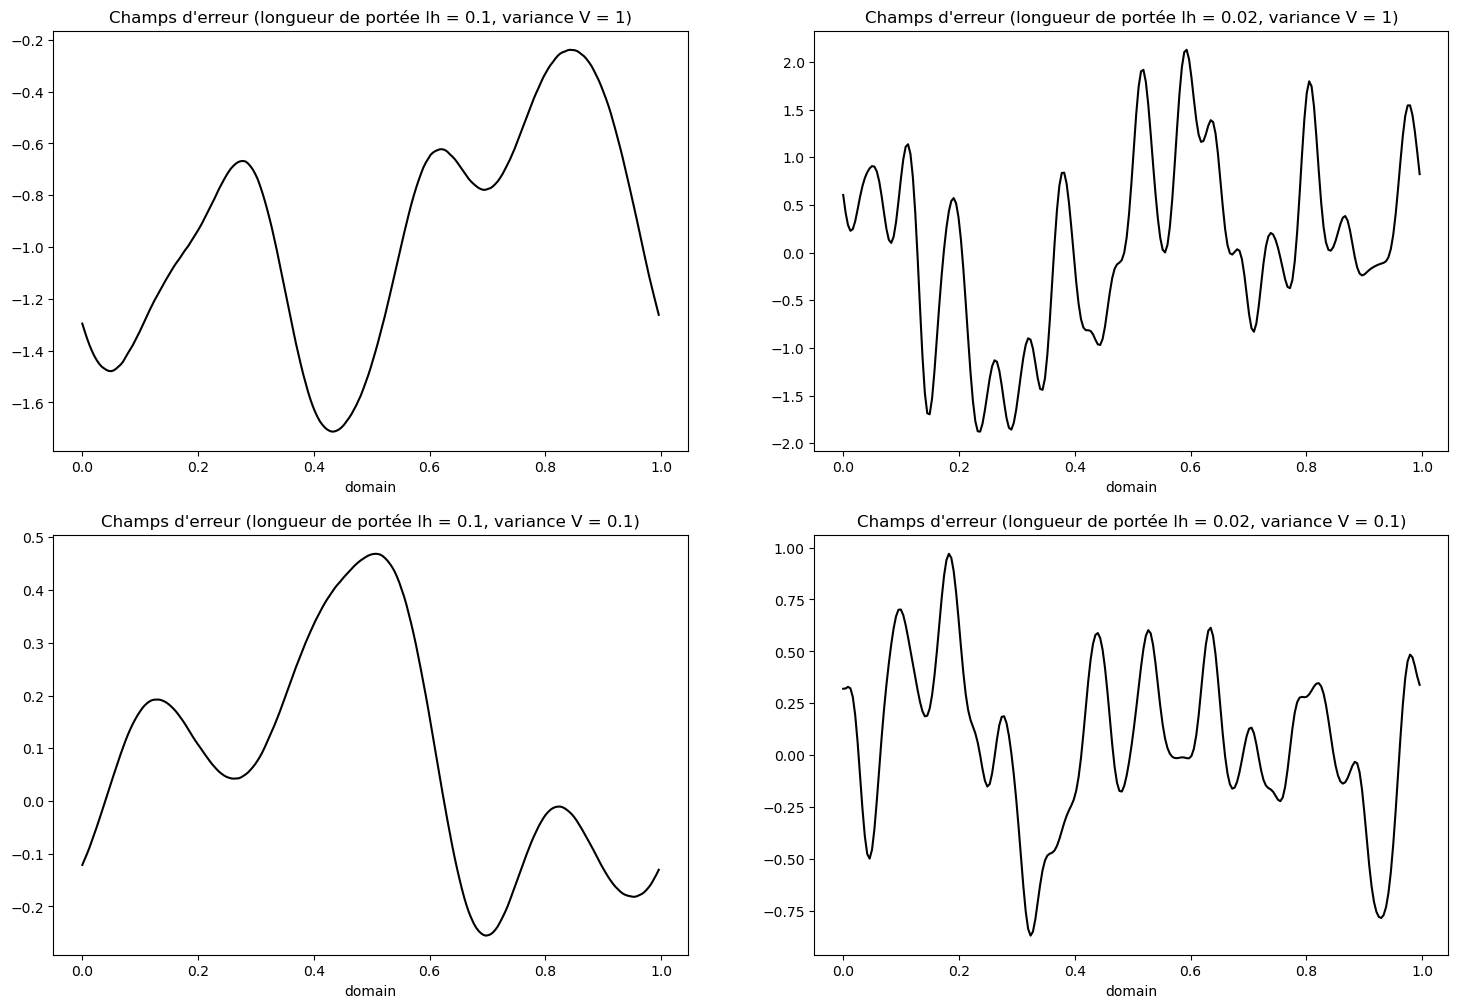

In [16]:
plt.figure(figsize=(18,12))

plt.subplot(221)
plt.plot(domain_1D.x[0], e1, color = 'black')

plt.title(f"Champs d'erreur (longueur de portée lh = {lh[0]}, variance V = {V[0]})")
plt.xlabel('domain')

plt.subplot(222)
plt.plot(domain_1D.x[0], e2, color = 'black')

plt.title(f"Champs d'erreur (longueur de portée lh = {lh[1]}, variance V = {V[0]})")
plt.xlabel('domain')

plt.subplot(223)
plt.plot(domain_1D.x[0], e3, color = 'black')

plt.title(f"Champs d'erreur (longueur de portée lh = {lh[0]}, variance V = {V[1]})")
plt.xlabel('domain')

plt.subplot(224)
plt.plot(domain_1D.x[0], e4, color = 'black')

plt.title(f"Champs d'erreur (longueur de portée lh = {lh[1]}, variance V = {V[1]})")
plt.xlabel('domain')

Lorsque la longueur de portée est grande, le champs d'erreur présente moins d'oscillation : la variabilité de l'erreur sur le domaine est moins importante. Lorsque la variance est grande, le maximum des erreurs sur le domaine est grand.

## 2) Génération d'erreur avec les champs de variance et de longueur de portée hétérogènes

### Matrice de covariance

In [17]:
V = np.array([2]*domain_1D.shape[0])
lh = np.array([lh[0]]*domain_1D.shape[0])

V_heterogeneous =  np.array(0.006 - 0.004*np.cos(2*np.pi*domain_1D.x[0]))
V_heterogeneous2 = np.array(1.1 + 0.9*np.cos(2*np.pi*domain_1D.x[0]))
lh_heterogeneous = np.array(0.06+ 0.04*np.cos(2*np.pi*domain_1D.x[0]))

Text(0.5, 0, 'domain')

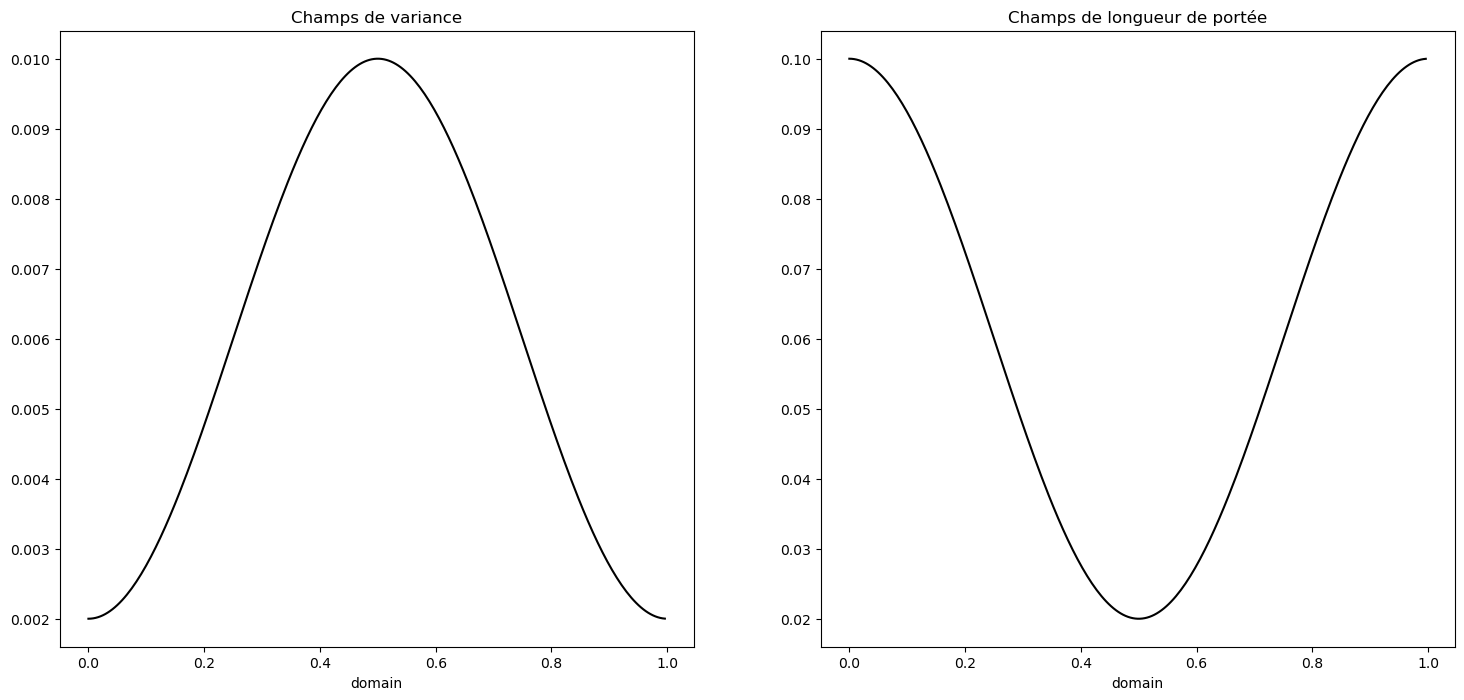

In [18]:
plt.figure(figsize=(18,8))

plt.subplot(121)
plt.plot(domain_1D.x[0], V_heterogeneous, color='black')

plt.title('Champs de variance')
plt.xlabel('domain')

plt.subplot(122)
plt.plot(domain_1D.x[0], lh_heterogeneous, color='black')

plt.title('Champs de longueur de portée')
plt.xlabel('domain')


In [19]:
matrix_V_hetero = Covariance_matrix(domain_1D, V_heterogeneous, lh)
matrix_lh_hetero = Covariance_matrix(domain_1D, V, lh_heterogeneous)
matrix_hetero = Covariance_matrix(domain_1D, V_heterogeneous, lh_heterogeneous)
matrix_hetero2 = Covariance_matrix(domain_1D, V_heterogeneous2, lh_heterogeneous)

Text(0, 0.5, 'domain')

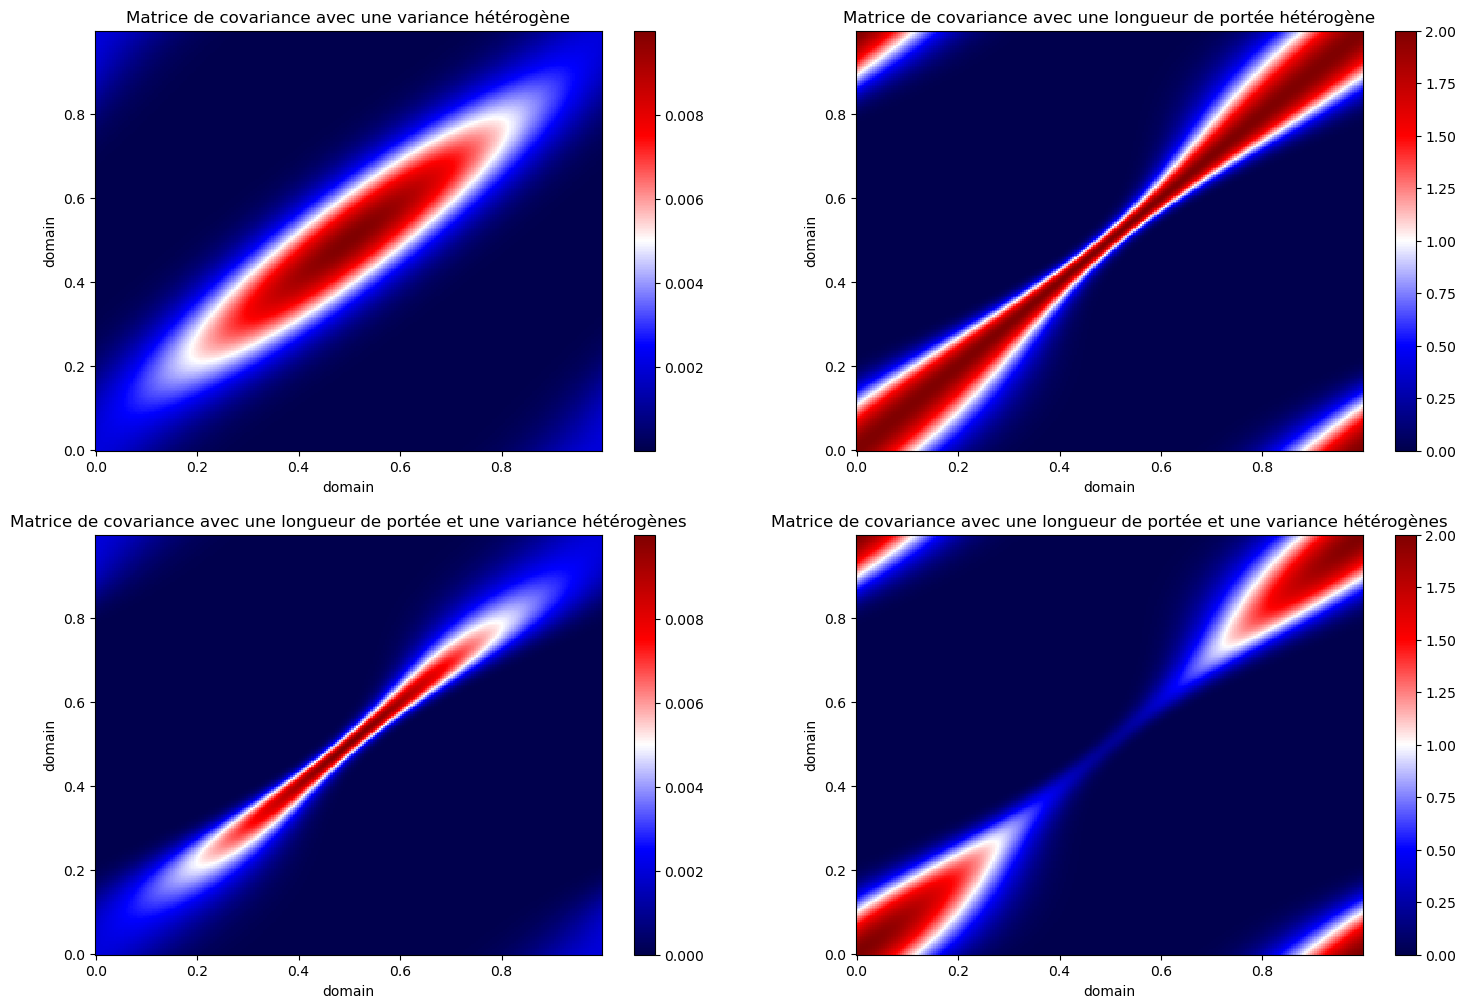

In [20]:
plt.figure(figsize = (18,12))

plt.subplot(221)
plt.pcolormesh(np.flip(domain_1D.x[0]),domain_1D.x[0],matrix_V_hetero, cmap = 'seismic')
plt.colorbar()

plt.title(f'Matrice de covariance avec une variance hétérogène')
plt.xlabel('domain')
plt.ylabel('domain')

plt.subplot(222)
plt.pcolormesh(np.flip(domain_1D.x[0]),domain_1D.x[0],matrix_lh_hetero, cmap = 'seismic')
plt.colorbar()

plt.title(f'Matrice de covariance avec une longueur de portée hétérogène')
plt.xlabel('domain')
plt.ylabel('domain')

plt.subplot(223)
plt.pcolormesh(np.flip(domain_1D.x[0]),domain_1D.x[0],matrix_hetero, cmap = 'seismic')
plt.colorbar()

plt.title(f'Matrice de covariance avec une longueur de portée et une variance hétérogènes')
plt.xlabel('domain')
plt.ylabel('domain')

plt.subplot(224)
plt.pcolormesh(np.flip(domain_1D.x[0]),domain_1D.x[0],matrix_hetero2, cmap = 'seismic')
plt.colorbar()

plt.title(f'Matrice de covariance avec une longueur de portée et une variance hétérogènes')
plt.xlabel('domain')
plt.ylabel('domain')

### Génération d'un champs d'erreur

In [21]:
e_V_hetero = make_sample_1D(domain_1D, V_heterogeneous, lh)
e_lh_hetero = make_sample_1D(domain_1D, V, lh_heterogeneous)
e_hetero = make_sample_1D(domain_1D, V_heterogeneous, lh_heterogeneous)
e_hetero2 = make_sample_1D(domain_1D, V_heterogeneous2, lh_heterogeneous)

Text(0.5, 0, 'domain')

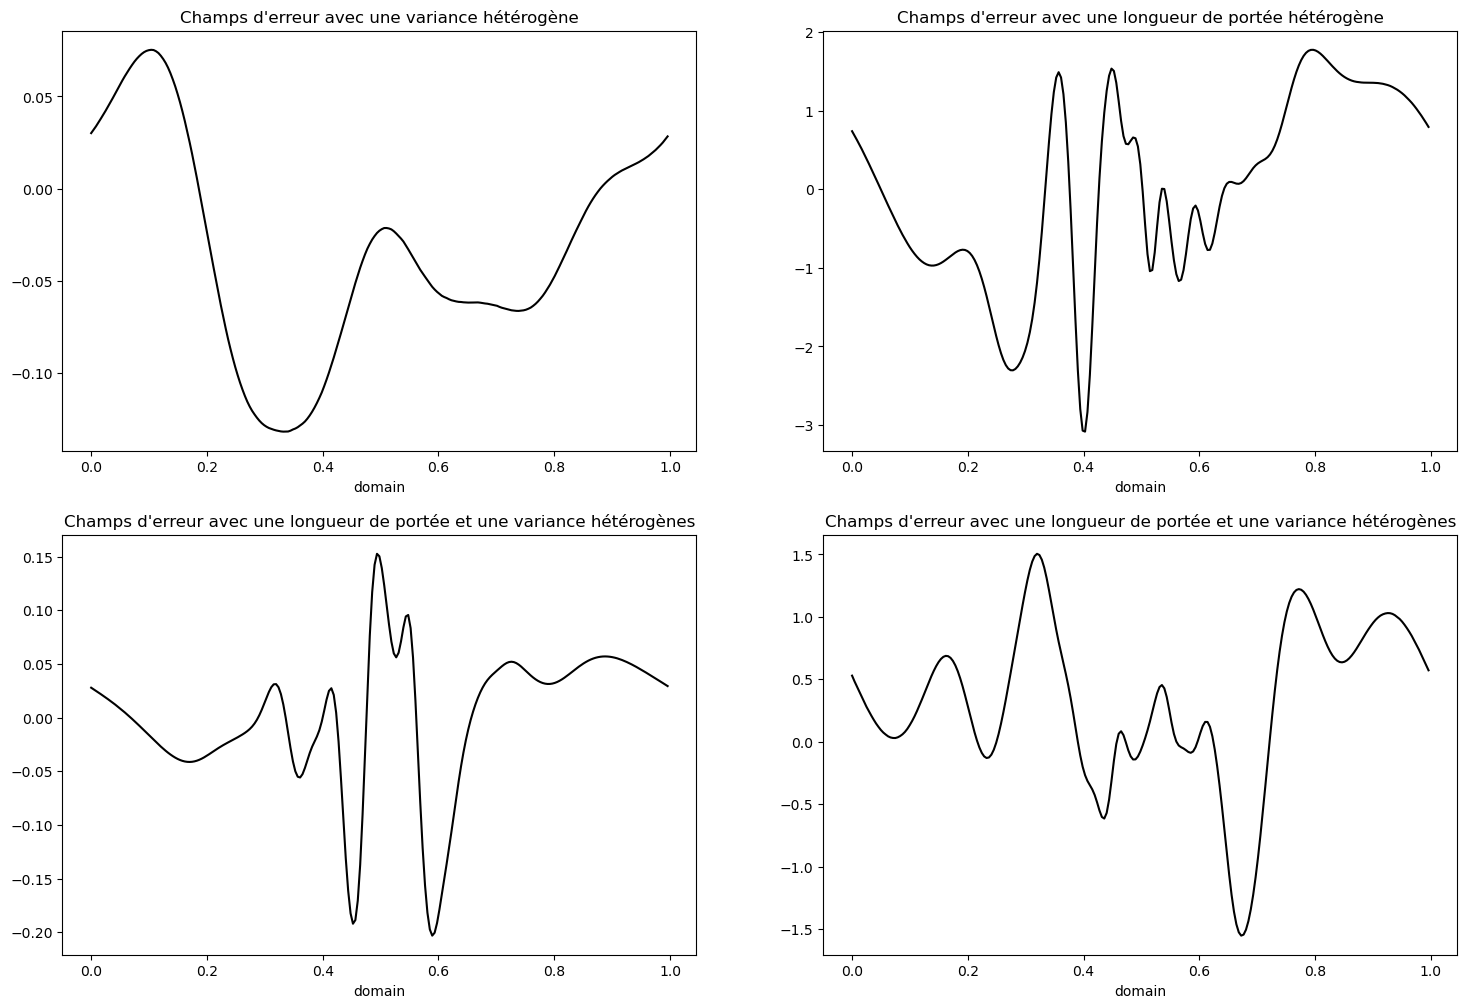

In [22]:
plt.figure(figsize=(18,12))

plt.subplot(221)
plt.plot(domain_1D.x[0], e_V_hetero, color = 'black')

plt.title(f"Champs d'erreur avec une variance hétérogène")
plt.xlabel('domain')

plt.subplot(222)
plt.plot(domain_1D.x[0], e_lh_hetero, color = 'black')

plt.title(f"Champs d'erreur avec une longueur de portée hétérogène")
plt.xlabel('domain')

plt.subplot(223)
plt.plot(domain_1D.x[0], e_hetero, color = 'black')

plt.title(f"Champs d'erreur avec une longueur de portée et une variance hétérogènes")
plt.xlabel('domain')

plt.subplot(224)
plt.plot(domain_1D.x[0], e_hetero2, color = 'black')

plt.title(f"Champs d'erreur avec une longueur de portée et une variance hétérogènes")
plt.xlabel('domain')

# III. Génération d'Ensemble

In [23]:
def make_error_ensemble_1D(domain, V, lh, Ne):
    ens = [(make_sample_1D(domain, V, lh)) for k in range(Ne)]
    return np.array(ens)

In [194]:
# Nombre de membre de l'ensemble
Ne = 2000

# generation de l'ensemble 
ens = make_error_ensemble_1D(domain_1D, V, lh, Ne)
ens.shape

In [195]:
# generation d'un ensemble avec variance et longueur de portée hétérogènes 
# Nombre de membre de l'ensemble
Ne2 = 6400

ens_heterogeneous = make_error_ensemble_1D(domain_1D, V_heterogeneous, lh_heterogeneous, Ne2)
ens_heterogeneous.shape

Text(0.5, 0, 'domain')

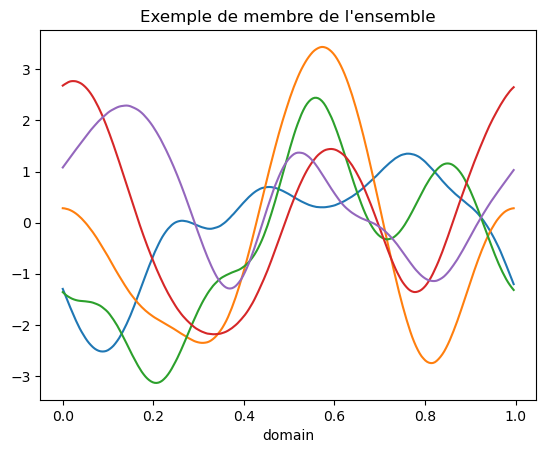

In [196]:
for i in range(5):
    plt.plot(domain_1D.x[0], ens[i])
    
plt.title("Exemple de membre de l'ensemble")
plt.xlabel('domain')

Text(0.5, 0, 'domain')

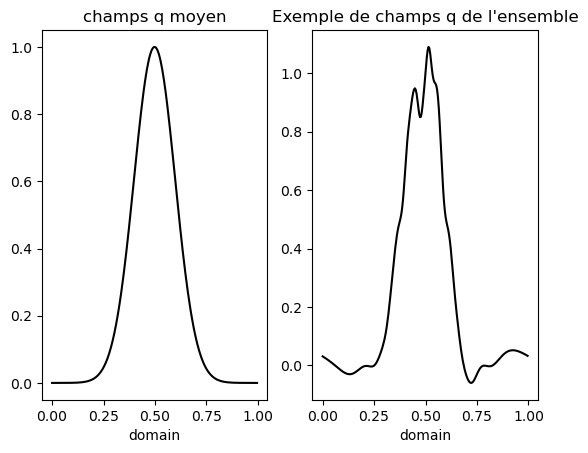

In [197]:
gauss = lambda dx, lh : np.exp(-0.5*dx**2/lh**2)

center = 0.5
sigma = 0.1

q_mean = np.roll(gauss(domain_1D.x[0]-domain_1D.x[0][domain_1D.shape[0]//2], sigma), int(-domain_1D.shape[0]//2+(center/domain_1D.lengths[0])*domain_1D.shape[0]))


plt.subplot(121)
plt.title('champs q moyen')
plt.plot(domain_1D.x[0], q_mean, color='black')
plt.xlabel('domain')


q = q_mean + ens_heterogeneous

plt.subplot(122)
plt.title("Exemple de champs q de l'ensemble")
plt.plot(domain_1D.x[0], q[0], color='black')
plt.xlabel('domain')

### Validation de l'ensemble

In [198]:
def estimate_covariance(ensemble):
    """ Estimate the covariance function from an ensemble
    ensemble : array
    """
    mean = ensemble.mean(0)
    error = (ensemble - mean)/np.sqrt(len(ensemble))
    return error.T @ error

In [199]:
# Calcul de la matrice de covariance a partir de l'ensemble
cov_ens = np.flip(estimate_covariance(ens), axis=0)
cov_ens_heterogeneous = np.flip((estimate_covariance(ens_heterogeneous)), axis=0)

In [200]:
# Calcul de la matrice de covariance reel
cov_reel = Covariance_matrix(domain_1D, V, lh)
cov_reel_heterogeneous = Covariance_matrix(domain_1D, V_heterogeneous, lh_heterogeneous)

Text(0.5, 1.0, "Erreur sur l'estimation de la matrice de covariance")

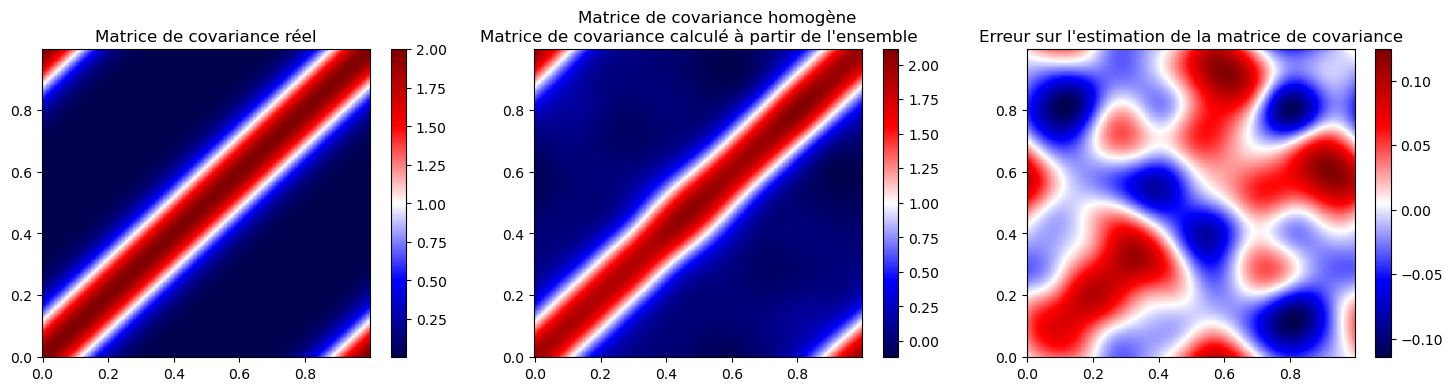

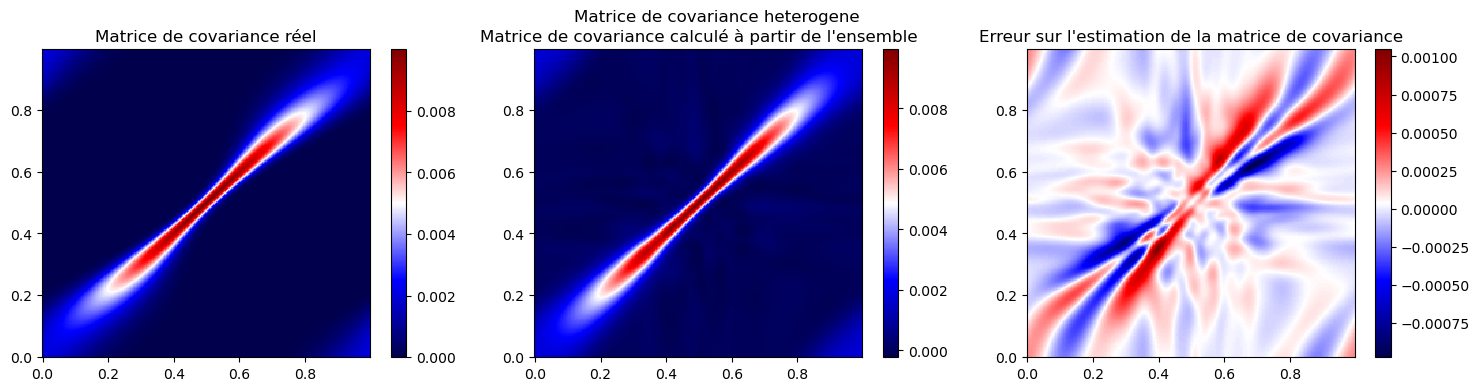

In [201]:
plt.figure(figsize=(18,4))

cmap = plt.colormaps['PiYG']

plt.suptitle('Matrice de covariance homogène')

plt.subplot(131)
plt.pcolormesh(np.flip(domain_1D.x[0]), domain_1D.x[0], cov_reel, cmap='seismic')
plt.colorbar()

plt.title('Matrice de covariance réel')

plt.subplot(132)
plt.pcolormesh(np.flip(domain_1D.x[0]), domain_1D.x[0], cov_ens, cmap='seismic')
plt.colorbar()

plt.title("Matrice de covariance calculé à partir de l'ensemble")

plt.subplot(133)
plt.pcolormesh(np.flip(domain_1D.x[0]), domain_1D.x[0], (cov_reel - cov_ens), cmap='seismic')
plt.colorbar()

plt.title("Erreur sur l'estimation de la matrice de covariance")

plt.figure(figsize=(18,4))

plt.suptitle('Matrice de covariance heterogene')

plt.subplot(131)
plt.pcolormesh(np.flip(domain_1D.x[0]), domain_1D.x[0], cov_reel_heterogeneous, cmap='seismic')
plt.colorbar()

plt.title('Matrice de covariance réel')

plt.subplot(132)
plt.pcolormesh(np.flip(domain_1D.x[0]), domain_1D.x[0], cov_ens_heterogeneous, cmap='seismic')
plt.colorbar()

plt.title("Matrice de covariance calculé à partir de l'ensemble")

plt.subplot(133)
plt.pcolormesh(np.flip(domain_1D.x[0]), domain_1D.x[0], (cov_reel_heterogeneous - cov_ens_heterogeneous), cmap='seismic')
plt.colorbar()

plt.title("Erreur sur l'estimation de la matrice de covariance")

On retrouve la matrice de covariance initiale avec une erreur de l'ordre de 10% avec un ensemble à 2000 membres. Cette erreur est probablement due à la sous représentativité de l'ensemble.

# IV. Propagation de l'ensemble 

In [202]:
from sympkf import Model 
from tqdm import tqdm

In [203]:
class Solve_EqDiagnostic_Psi(object):
    '''Classe qui résout l'équation q = laplacien(psi) - lambda*psi'''
    def __init__(self, lbda, domain):
        self.lbda = lbda
        self.domain = domain
        self.dim = len(domain.shape)
       
    
    def solve_fft(self, q):
        fft_list_freq = [2*np.pi*np.fft.fftfreq(self.domain.shape[i], self.domain.lengths[i]/self.domain.shape[i]) for i in range(self.dim)]
        if self.dim == 1:
            fft_q = np.fft.fft(q)
            k_square = fft_list_freq[0]**2
        elif self.dim == 2:
            fft_q = np.fft.fft2(q)
            fft_xx, fft_yy = np.meshgrid(fft_list_freq[0], fft_list_freq[1])
            k_square = (fft_xx**2 + fft_yy**2)
        fft_psi = -1/(k_square + self.lbda)*fft_q
        if self.dim == 1:
            return np.fft.ifft(fft_psi).real
        elif self.dim == 2:
            return np.fft.ifft2(fft_psi).real
    
    def solve_Jacobi(self, q, psi, max_iter = 10000, eps = 0.1):
        
        #correction du biais
        psi = (psi - psi.mean() - q.mean()/self.lbda)
        
        i = 0
        e_q = (q - (self.laplacien(psi) - lbda*psi))/q
        while  any(e > eps for e in np.ndarray.flatten(e_q)) and i < max_iter:
            psi = 1/(lbda+2*sum(1/np.array(self.domain.dx)**2))*(sum([(np.roll(psi, 1, axis=i) + np.roll(psi, -1, axis=i))/self.domain.dx[-i-1]**2 for i in range(len(self.domain.shape))]) - q)
            e_q = (self.laplacien(psi) - lbda*psi) - q
            i += 1
        return(psi, i)
    
    def validate_Solution(self, q, psi):
        q_diagnostic = self.laplacien(psi) - self.lbda* psi
        norm_error = sum(np.abs(q-q_diagnostic)**2)
        print("norme de l'erreur :", norm_error)    
        
        
    def laplacien(self, f):
        laplace_f = 0
        for i in range(self.dim):
            laplace_f += (np.roll(f, 1, axis = i) + np.roll(f, -1, axis = i) - 2*f)/(self.domain.dx[-(i+1)]**2)
        return laplace_f

In [204]:
class Dynamic_tourbillon_1D(Model):
    def __init__(self, lbda, domain, time_scheme= 'rk4'):
        super(Dynamic_tourbillon_1D, self).__init__(time_scheme)
        
        self.lbda = lbda
        self.domain = domain

        self.set_solve_psi()
        
        self.window = None
        
    def set_saved_times(self, window, saved_times):
        self.saved_times = self._check_saved_times(window, saved_times)
        
    def set_solve_psi(self):
        self.solve_psi = Solve_EqDiagnostic_Psi(self.lbda, domain = self.domain)
        
    def psi(self, t, state):
        
        
        psi = self.solve_psi.solve_fft(state)
        
        # save trajectory of psi
        if t in self.traj_psi:
            self.traj_psi[t].append(psi)
        
        
        return psi
        
    def u(self, t, psi):
        
        u = (np.roll(psi, -1) - np.roll(psi, 1))/(2*self.domain.dx[0])
        
        # save trajectory of u
        if t in self.traj_u:
            self.traj_u[t].append(u)
        
        return u
    
    def trend(self, t, state):
        
        psi = self.psi(t, state)
        
        u = self.u(t, psi)
        
        
        
        
        return -u*(np.roll(state, -1) - np.roll(state, 1))/(2*self.domain.dx[0])
    
    
    def ensemble_forecast(self, window, states, saved_times=None, parallel=True, nb_pool=8):
        
        self.set_saved_times(window, saved_times)
        
        saved_times = self.saved_times
        self.traj_u = {time:[] for time in saved_times}
        self.traj_psi = {time:[] for time in saved_times}
        
        forecasts =  super().ensemble_forecast(window, states, saved_times=saved_times, parallel=parallel, nb_pool=nb_pool)
        
        return forecasts
    
    '''
    def ensemble_forecast(self, window, states, saved_times=None, parallel=True, nb_pool=8):
        
        self.set_window(window)
        
        forecasts = super(Dynamic_tourbillon_1D, self).ensemble_forecast(self, window, states, saved_times=saved_times, parallel=parallel, nb_pool=nb_pool)
            
        return forecasts
            '''

In [205]:
lbda = 0.1
domain = domain_1D
u = np.array([0.4]*domain.shape[0])

In [206]:
             # default time step
refine_time = int(1)    # used to increase the time resolution (reduce the time step)
time_simulation = 1.
dt = 0.002/refine_time
times = np.arange(0, refine_time, dt)
saved_times = times[::50*refine_time] 


In [207]:
saved_times

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [208]:
test = Dynamic_tourbillon_1D(lbda, domain)

In [209]:
saved_times = test._check_saved_times(times, saved_times)


forecasts = test.ensemble_forecast(times, ens_heterogeneous, saved_times, parallel = False)




## Evaluation des métriques de l'ensemble

In [210]:
class EnsembleDiagnosis(object):
    """ Diagnosis tool of the variance and of the anisotropy for a covariance 
    model parameterized from this two features (VLATcov model)
    """
    def __init__(self, ensemble, base_space):
        self.base_space = base_space
        
        if isinstance(ensemble, list):
            ensemble = np.array(ensemble)
        
        if len(ensemble.shape)==3:
            ensemble = np.array([elm[0] for elm in ensemble])
        
        # 1) Computation of the mean
        self.mean = ensemble.mean(axis=0)
        
        # 2) Computation of the variance
        self.std = ensemble.std(axis=0)
        self.variance = self.std*self.std
        
        # 3) Computation of the metric terms 
        #  we use the formula g_ij = E[(D_i eps)(D_j eps)]
        
        #  a) Computation of the normalized error
        epsilon = (ensemble-self.mean)/self.std
        
        #  b) Computation of derivatives (uses centered second order finite difference)
        n = self.base_space.shape[0]
        K = np.arange(n)
        kp = (K+1)%n
        km = (K-1)%n
        dx = self.base_space.dx[0]
        Depsilon = np.array([(eps[kp]-eps[km])/(2*dx) for eps in epsilon])
        self.metric = (Depsilon*Depsilon).mean(axis=0)     # see Pannekoucke et al. (2018) for details   
        
        # Computation of the diffusion tensor
        self.aspect = 1/self.metric
        self.length_scale = np.sqrt(self.aspect)

In [211]:
def plot_diagnosis(mean, variance, length_scale, name):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, time in enumerate(variance.keys()):
        if i%2 == 0:
            fig.suptitle(f'Metrics of field {name}')


            ax[0].plot(domain_1D.x[0], mean[time], color='black', alpha = i/len(variance.keys()))

            ax[0].set_title('Champs de la moyenne')
            ax[0].set_xlabel('domain')


            ax[1].plot(domain_1D.x[0], variance[time], color='black', alpha = i/len(variance.keys()))

            ax[1].set_title('Champs de la Variance des erreurs')
            ax[1].set_xlabel('domain')


            ax[2].plot(domain_1D.x[0], length_scale[time], color='black', alpha = i/len(length_scale.keys()))

            ax[2].set_title('Champs de la longueur de portée')
            ax[2].set_xlabel('domain')

In [212]:
variance_q, variance_psi, variance_u = {time:[] for time in saved_times}, {time:[] for time in saved_times}, {time:[] for time in saved_times}
length_scale_q, length_scale_psi, length_scale_u = {time:[] for time in saved_times}, {time:[] for time in saved_times}, {time:[] for time in saved_times}
mean_q, mean_psi, mean_u = {time:[] for time in saved_times}, {time:[] for time in saved_times}, {time:[] for time in saved_times}

for time in forecasts.keys():
    diagnostic_q = EnsembleDiagnosis(forecasts[time], domain)
    diagnostic_psi = EnsembleDiagnosis(test.traj_psi[time], domain)
    diagnostic_u = EnsembleDiagnosis(test.traj_u[time], domain)
    
    # diagnostic for q
    mean_q[time] = diagnostic_q.mean
    variance_q[time] = diagnostic_q.variance
    length_scale_q[time] = diagnostic_q.length_scale
    
    # diagnostic for psi
    mean_psi[time] = diagnostic_psi.mean
    variance_psi[time] = diagnostic_psi.variance
    length_scale_psi[time] = diagnostic_psi.length_scale
    
    
    # diagnostic for u
    mean_u[time] = diagnostic_u.mean
    variance_u[time] = diagnostic_u.variance
    length_scale_u[time] = diagnostic_u.length_scale

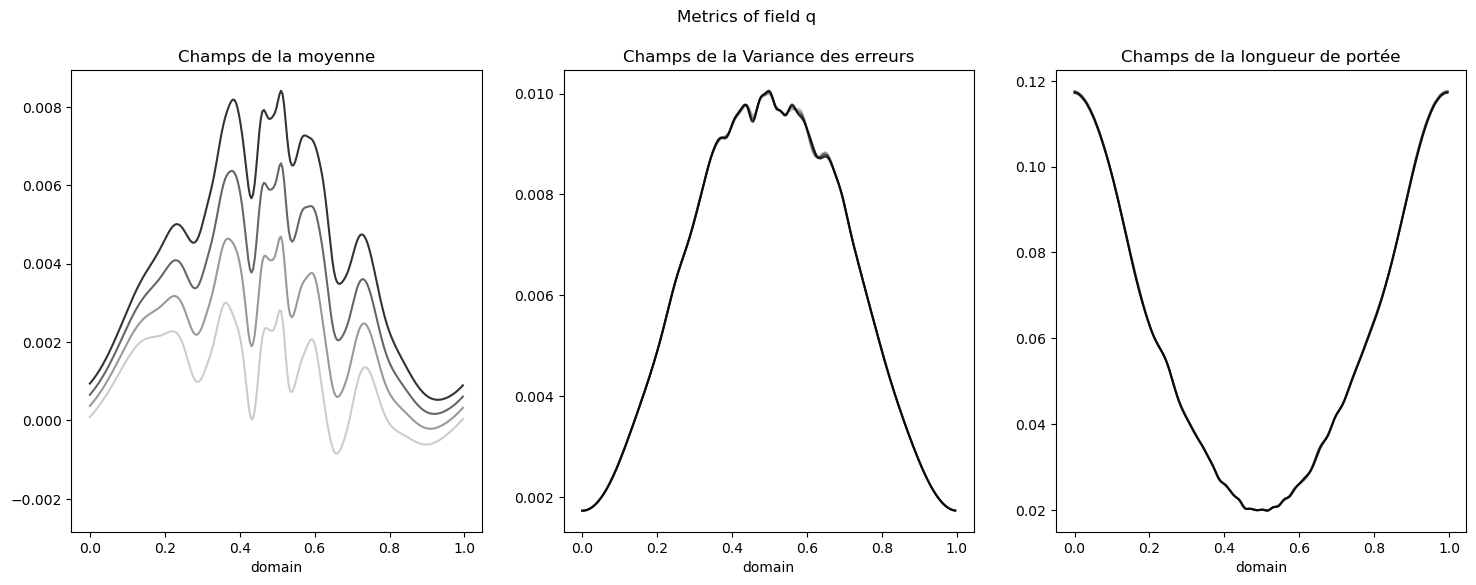

In [213]:
plot_diagnosis(mean_q, variance_q, length_scale_q, name= 'q')

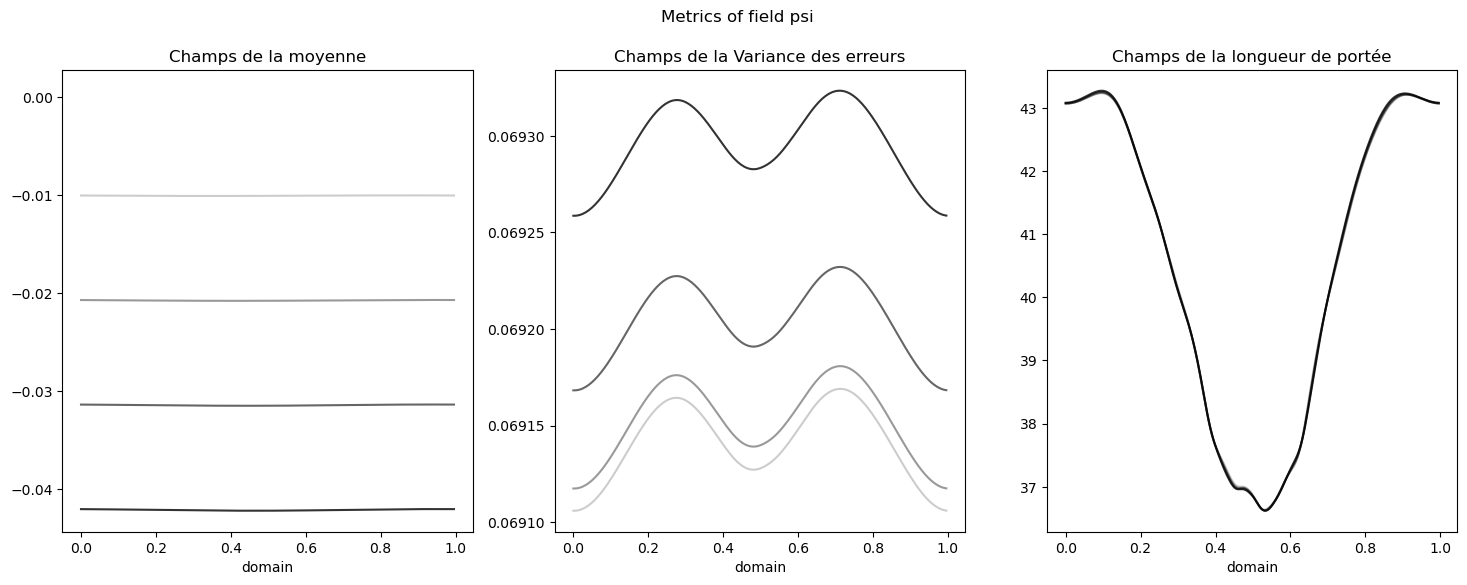

In [214]:
plot_diagnosis(mean_psi, variance_psi, length_scale_psi, name= 'psi')

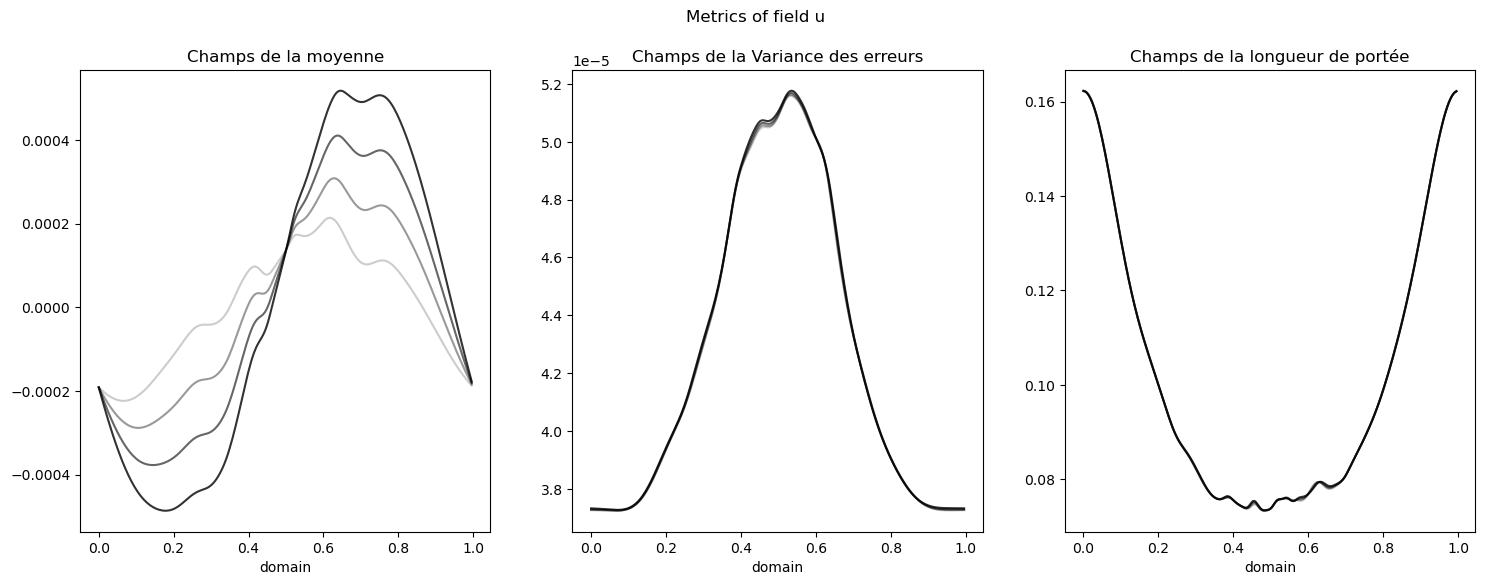

In [215]:
plot_diagnosis(mean_u, variance_u, length_scale_u, name= 'u')